In [2]:
import sys

from pathlib import Path
from datetime import timedelta


import tensorflow as tf
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import torch
from tensorflow.keras.layers import Flatten, Dense, InputLayer, Input, dot, concatenate, GRU, Bidirectional
from tensorflow.keras import Sequential, Model, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

#from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from tensorflow.keras import backend as K

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12335858880617623064
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6570337895
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17165723635867639326
physical_device_desc: "device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [4]:
TRAIN_DATASET = sorted([x for x in Path("C:\\Users\\munan\\Downloads\\data\\HAI 1.0\\train-dataset\\").glob("*.csv")])
TRAIN_DATASET

[WindowsPath('C:/Users/munan/Downloads/data/HAI 1.0/train-dataset/train1.csv'),
 WindowsPath('C:/Users/munan/Downloads/data/HAI 1.0/train-dataset/train2.csv')]

In [5]:
TEST_DATASET = sorted([x for x in Path("C:\\Users\\munan\\Downloads\\data\\HAI 1.0\\test-dataset\\").glob("*.csv")])
TEST_DATASET

[WindowsPath('C:/Users/munan/Downloads/data/HAI 1.0/test-dataset/test1.csv'),
 WindowsPath('C:/Users/munan/Downloads/data/HAI 1.0/test-dataset/test2.csv')]

In [8]:
VALIDATION_DATASET = sorted([x for x in Path("data/validation").glob("*.csv")])
VALIDATION_DATASET

[WindowsPath('data/validation/validation.csv')]

In [6]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [7]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,attack,attack_P1,attack_P2,attack_P3
0,2019-09-11 20:00:00,0.0983,1.0702,399.2321,1110.3986,32.0000,0.0,28.9981,35.7395,0.0,...,-0.0004,330.6568,328.9388,50.9871,9973.0,27629.0,0,0,0,0
1,2019-09-11 20:00:01,0.0983,1.0699,399.2321,1110.3986,32.0000,0.0,29.9914,35.7388,0.0,...,-0.0012,330.2228,329.3728,50.9871,9973.0,27629.0,0,0,0,0
2,2019-09-11 20:00:02,0.0983,1.0703,399.2321,1110.3986,32.0000,0.0,27.0122,35.7399,0.0,...,0.0018,332.0493,329.7526,50.9871,9973.0,27629.0,0,0,0,0
3,2019-09-11 20:00:03,0.0983,1.0719,399.2321,1110.3986,32.0000,0.0,32.9705,35.7452,0.0,...,0.0033,331.5249,331.0547,50.9871,9973.0,27629.0,0,0,0,0
4,2019-09-11 20:00:04,0.0983,1.0710,399.2321,1110.3986,32.0000,0.0,30.9843,35.7422,0.0,...,0.0015,333.1706,331.1631,50.9871,9973.0,27629.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241195,2019-11-04 14:59:55,0.1001,1.5194,395.3508,1120.8154,29.4139,0.0,33.9638,33.4685,0.0,...,-0.0007,366.9524,362.7749,0.0000,10026.0,27548.0,0,0,0,0
241196,2019-11-04 14:59:56,0.1001,1.5220,395.3508,1120.8154,29.4139,0.0,35.9501,33.4723,0.0,...,-0.0007,365.7950,363.7876,0.0000,10026.0,27549.0,0,0,0,0
241197,2019-11-04 14:59:57,0.1001,1.5235,395.3508,1120.8154,29.4139,0.0,36.9430,33.4833,0.0,...,-0.0003,367.0790,364.0950,0.0000,10026.0,27547.0,0,0,0,0
241198,2019-11-04 14:59:58,0.1001,1.5279,395.3508,1120.8154,29.4139,0.0,35.9501,33.4837,0.0,...,0.0008,367.5492,364.5110,0.0000,10026.0,27551.0,0,0,0,0


In [8]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD]) # delete 'time' column
print(VALID_COLUMNS_IN_TRAIN_DATASET)
print(len(VALID_COLUMNS_IN_TRAIN_DATASET))

Index(['P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005', 'P1_B4002', 'P1_B4005',
       'P1_B400B', 'P1_B4022', 'P1_FCV01D', 'P1_FCV01Z', 'P1_FCV02D',
       'P1_FCV02Z', 'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT02',
       'P1_FT02Z', 'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z', 'P1_LIT01',
       'P1_PCV01D', 'P1_PCV01Z', 'P1_PCV02D', 'P1_PCV02Z', 'P1_PIT01',
       'P1_PIT02', 'P1_TIT01', 'P1_TIT02', 'P2_24Vdc', 'P2_Auto', 'P2_Emgy',
       'P2_On', 'P2_SD01', 'P2_SIT01', 'P2_TripEx', 'P2_VT01e', 'P2_VXT02',
       'P2_VXT03', 'P2_VYT02', 'P2_VYT03', 'P3_LCP01D', 'P3_LCV01D', 'P3_LH',
       'P3_LL', 'P3_LT01', 'P4_HT_FD', 'P4_HT_LD', 'P4_HT_PO', 'P4_HT_PS',
       'P4_LD', 'P4_ST_FD', 'P4_ST_LD', 'P4_ST_PO', 'P4_ST_PS', 'P4_ST_PT01',
       'P4_ST_TT01', 'attack', 'attack_P1', 'attack_P2', 'attack_P3'],
      dtype='object')
63


In [9]:
# column 별 최대 최소
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [10]:
print(TAG_MIN)
print(TAG_MAX)

P1_B2004          0.029300
P1_B2016          0.100179
P1_B3004        392.306900
P1_B3005        983.115200
P1_B4002         29.413900
                  ...     
P4_ST_TT01    15203.000000
attack            0.000000
attack_P1         0.000000
attack_P2         0.000000
attack_P3         0.000000
Length: 63, dtype: float64
P1_B2004          0.101900
P1_B2016          2.112192
P1_B3004        467.296500
P1_B3005       1120.815400
P1_B4002         32.367300
                  ...     
P4_ST_TT01    27630.000000
attack            1.000000
attack_P1         1.000000
attack_P2         0.000000
attack_P3         0.000000
Length: 63, dtype: float64


In [11]:
# 최대 최소를 이용하여 정규화
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [12]:
# ewm = 지수 이동 평균, 

TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.85).mean()
TRAIN_DF

,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,P1_FCV01Z,...,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,attack,attack_P1,attack_P2,attack_P3
0,0.950413,0.482115,0.092349,0.924352,0.875635,0.0,0.003453,0.747782,0.0,0.000303,...,0.482464,0.512735,0.510764,0.990676,0.28169,0.999920,0.0,0.0,0.0,0.0
1,0.950413,0.481985,0.092349,0.924352,0.875635,0.0,0.003754,0.747649,0.0,0.000303,...,0.475871,0.510816,0.512788,0.990676,0.28169,0.999920,0.0,0.0,0.0,0.0
2,0.950413,0.482138,0.092349,0.924352,0.875635,0.0,0.002908,0.747838,0.0,0.000367,...,0.499279,0.518492,0.514784,0.990676,0.28169,0.999920,0.0,0.0,0.0,0.0
3,0.950413,0.482837,0.092349,0.924352,0.875635,0.0,0.004546,0.748852,0.0,0.000248,...,0.514805,0.517350,0.521015,0.990676,0.28169,0.999920,0.0,0.0,0.0,0.0
4,0.950413,0.482561,0.092349,0.924352,0.875635,0.0,0.004204,0.748446,0.0,0.000295,...,0.502623,0.524293,0.522440,0.990676,0.28169,0.999920,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241195,0.975207,0.704740,0.040591,1.000000,0.000000,0.0,0.005161,0.250082,0.0,0.000075,...,0.480495,0.697583,0.692033,0.000000,0.38833,0.993450,0.0,0.0,0.0,0.0
241196,0.975207,0.706377,0.040591,1.000000,0.000000,0.0,0.005764,0.251059,0.0,0.000075,...,0.479752,0.692329,0.696794,0.000000,0.38833,0.993477,0.0,0.0,0.0,0.0
241197,0.975207,0.707256,0.040591,1.000000,0.000000,0.0,0.006148,0.253254,0.0,0.000075,...,0.482863,0.697091,0.698909,0.000000,0.38833,0.993344,0.0,0.0,0.0,0.0
241198,0.975207,0.709247,0.040591,1.000000,0.000000,0.0,0.005912,0.253657,0.0,0.000075,...,0.492193,0.699837,0.701122,0.000000,0.38833,0.993598,0.0,0.0,0.0,0.0


In [13]:
# 정규화된 값

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [14]:
boundary_check(TRAIN_DF)

(False, False, False)

In [15]:
np_train = np.array(TRAIN_DF)
input_shape = np_train.shape[1]
print(np_train.shape, input_shape)

(550800, 63) 63


In [16]:
stride_10_data = []
for i in range(int(np_train.shape[0]/3)):
    stride_10_data.append(np_train[i+3])

In [17]:
stride_10_data = np.array(stride_10_data)
stride_10_data.shape

(183600, 63)

In [19]:
# functional api
squ_input = Input(shape = (input_shape,1)) # input = 17, des_shape = 17

print(squ_input)

squ_gru = Bidirectional(GRU(units=15, return_sequences=True))(squ_input)
squ_gru = Bidirectional(GRU(units=15, return_sequences=True))(squ_gru)
squ_flat = Flatten()(squ_gru)
squ_fc = Dense(200)(squ_flat)
squ_fc = Dense(input_shape)(squ_fc)
hai_model = Model(inputs = [squ_input], outputs = [squ_fc])



Tensor("input_1:0", shape=(None, 63, 1), dtype=float32)


In [80]:
#LSTM
from tensorflow import keras
from tensorflow.keras import layers

#squ_input = Input(shape = (input_shape,1)) # input = 17, des_shape = 17

print(squ_input)

hai_model = keras.Sequential()

hai_model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(None,1)))
hai_model.add(layers.Bidirectional(layers.LSTM(64)))
hai_model.add(layers.Dense(200))
hai_model.add(layers.Dense(input_shape))
hai_model = Model(inputs = [squ_input], outputs = [squ_fc])

Tensor("input_1:0", shape=(None, 63, 1), dtype=float32)


In [81]:
hai_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 63, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 63, 30)            1620      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 63, 30)            4230      
_________________________________________________________________
flatten (Flatten)            (None, 1890)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               378200    
_________________________________________________________________
dense_1 (Dense)              (None, 63)                12663     
Total params: 396,713
Trainable params: 396,713
Non-trainable params: 0
_____________________________________________________

In [82]:
hai_model.compile(optimizer='adam', loss='mse')

In [83]:
stride_10_data.shape

(183600, 63)

In [84]:
test=np.array(stride_10_data)

In [85]:
test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [86]:
test.shape[0]

183600

In [87]:
test=np.reshape(test,(test.shape[0],63,1))

In [88]:
history = hai_model.fit(x = test, y = test, epochs=50, batch_size = 512)

Train on 183600 samples
Epoch 1/50
   512/183600 [..............................] - ETA: 15:54

UnknownError:  [_Derived_]  Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model_1/bidirectional/forward_gru/StatefulPartitionedCall]] [Op:__inference_distributed_function_30051]

Function call stack:
distributed_function -> distributed_function -> distributed_function


In [23]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


In [24]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [25]:
VALIDATION_DF.shape

(43201, 79)

In [26]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [63]:
validation_data = np.array(VALIDATION_DF)

In [64]:
y_predict = []
#results = new_hai_model.evaluate(test_data, test_data, batch_size=128)
y_pred = hai_model.predict(validation_data)
y_predict.append(y_pred)

In [65]:
y_predict = np.array(y_predict)
y_predict = y_predict.reshape(y_predict.shape[1], y_predict.shape[2])
print(y_predict.shape)

In [68]:
distance = abs(y_predict-test_data)
ANOMALY_SCORE = np.mean(distance, axis=1)
VALIDATION_DF_y = VALIDATION_DF_RAW['attack']
print(VALIDATION_DF_y.shape)

(43201,)


In [71]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

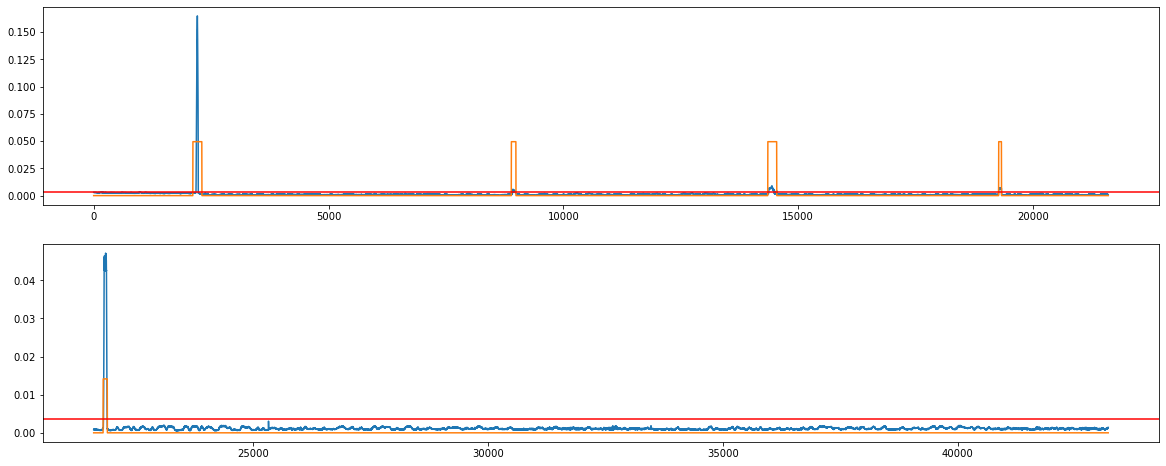

In [72]:
THRESHOLD = 0.0035
check_graph(ANOMALY_SCORE, VALIDATION_DF_y, piece=2, THRESHOLD=THRESHOLD)

In [73]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [74]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), (43201,))

In [75]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (43201,))

In [76]:
ATTACK_LABELS.shape[0] == LABELS.shape[0]

True

In [77]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.904 (TaP: 1.000, TaR: 0.824)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


In [60]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,...,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,...,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,...,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,...,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,...,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,...,824.82147,100.0,1.35666,9.62203,36.47460,11.78894,357.27722,361.14728,32.0,6.2809
92397,2020-07-31 12:29:57,420.08923,12.0,10,48.31848,-0.7498,97.19238,784.07184,28.03598,224,...,823.51697,100.0,1.35513,9.48747,36.47460,11.78894,357.29529,359.84521,32.0,6.3602
92398,2020-07-31 12:29:58,420.24258,12.0,10,48.31848,-0.6076,97.19238,786.83881,28.02642,208,...,824.82147,100.0,1.35666,9.57787,36.48986,11.78894,357.27722,360.60474,32.0,6.3742
92399,2020-07-31 12:29:59,420.24258,12.0,10,48.31848,-0.4618,97.19238,786.66138,28.03341,200,...,833.51904,100.0,1.35513,9.56291,36.48986,11.78894,357.80170,357.42188,32.0,6.2864


In [90]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,...,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.171634,0.000999,0.300187,0.426398,0.010417,0.137445,...,0.680584,0.0,0.317842,0.450701,0.230344,0.944440,0.223121,0.198499,0.26162,0.650106
2,0.272825,0.0,0.0,0.828325,0.166747,0.000930,0.298514,0.434738,0.010417,0.137227,...,0.678007,0.0,0.318290,0.451229,0.229791,0.944440,0.220223,0.196880,0.26162,0.644285
3,0.273182,0.0,0.0,0.828325,0.158478,0.000992,0.353980,0.482056,0.010417,0.190063,...,0.675769,0.0,0.318335,0.449470,0.229736,0.944440,0.218893,0.193823,0.26162,0.583093
4,0.272773,0.0,0.0,0.828325,0.174269,0.000998,0.370123,0.556914,0.010417,0.266280,...,0.682626,0.0,0.317891,0.450884,0.229731,0.944440,0.212932,0.198888,0.26162,0.523348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619520,0.0,0.0,0.073426,0.532147,0.998079,0.476720,0.581066,0.017489,0.358745,...,0.596406,1.0,0.319337,0.285888,0.790598,0.083339,0.466152,0.485809,0.26162,0.622130
92397,0.619561,0.0,0.0,0.073426,0.581096,0.998079,0.446527,0.680775,0.016853,0.386044,...,0.595956,1.0,0.318439,0.281450,0.790543,0.083339,0.466370,0.482229,0.26162,0.658390
92398,0.620899,0.0,0.0,0.073426,0.639210,0.998079,0.474916,0.436791,0.015748,0.453718,...,0.596761,1.0,0.319252,0.284110,0.796619,0.083339,0.466330,0.484406,0.26162,0.666539
92399,0.621033,0.0,0.0,0.073426,0.699587,0.998079,0.475741,0.598077,0.015116,0.563381,...,0.602505,1.0,0.318431,0.283862,0.797227,0.083339,0.468106,0.474004,0.26162,0.638988


In [91]:
boundary_check(TEST_DF)

(True, True, False)

In [92]:
test_data = np.array(TEST_DF)

In [ ]:
predict = []
#results = new_hai_model.evaluate(test_data, test_data, batch_size=128)
test_y = hai_model.predict(test_data)
predict.append(test_y)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [94]:
predict = np.array(predict)
#predict = predict.reshape(predict.shape[1], predict.shape[2])
print(predict.shape)

(1, 43201, 79)


In [ ]:
distance = abs(predict-test_data)
test_ANOMALY_SCORE = np.mean(distance, axis=1)


In [ ]:
check_graph(test_ANOMALY_SCORE, piece=3, THRESHOLD=THRESHOLD)

In [ ]:
test_LABELS = put_labels(test_ANOMALY_SCORE, THRESHOLD)
test_LABELS, test_LABELS.shape

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

In [ ]:
submission.to_csv('baseline.csv', index=False)